In [1]:
import torch
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories
from mlcolvar.utils.io import create_dataset_from_files


dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb'],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)

datamodule_graph = DictModule(dataset_graph, lengths=[0.8, 0.2], shuffle=[1, 0])
print(datamodule_graph)


dataset_ff = create_dataset_from_files(file_names=['data/colvar_r.dat',
                                                   'data/colvar_p.dat'],
                                                   filter_args={'regex': 'd'})

datamodule_ff = DictModule(dataset_ff, lengths=[0.8, 0.2], shuffle=[1, 0])


DictModule(dataset -> DictDataset( "data_list": 1600, "z_table": [6, 9], "cutoff": 8.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=0.8, batch_size=1600, shuffle=1),
		     valid_loader -> DictLoader(length=0.2, batch_size=1600, shuffle=0))
Class 0 dataframe shape:  (800, 24)
Class 1 dataframe shape:  (800, 24)

 - Loaded dataframe (1600, 24): ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'walker', 'labels']
 - Descriptors (1600, 21): ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']


In [2]:
from mlcolvar.cvs import AutoEncoderCV
!rm -r checkpoints

model = AutoEncoderCV([21,1])

from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=True,
    accelerator='cpu',
    max_epochs=5,
    enable_model_summary=False
)

trainer.fit(model, datamodule_ff)
torch.load('checkpoints/epoch=4-step=5.ckpt')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


{'epoch': 4,
 'global_step': 5,
 'pytorch-lightning_version': '2.1.3',
 'state_dict': OrderedDict([('norm_in.mean',
               tensor([0.1468, 0.1508, 0.1509, 0.2031, 0.2564, 0.2317, 0.2458, 0.2498, 0.1993,
                       0.1505, 0.1332, 0.2544, 0.3068, 0.3421, 0.2865, 0.2851, 0.3215, 0.3452,
                       0.3085, 0.2619, 0.2324])),
              ('norm_in.range',
               tensor([0.0036, 0.0066, 0.0061, 0.0474, 0.0114, 0.0055, 0.0135, 0.0126, 0.0465,
                       0.0055, 0.0050, 0.0065, 0.0526, 0.0296, 0.0396, 0.0307, 0.0257, 0.0382,
                       0.0586, 0.0380, 0.0064])),
              ('encoder.nn.0.weight',
               tensor([[-0.2054, -0.0721, -0.0196, -0.1898,  0.0537, -0.1277,  0.0712,  0.0602,
                        -0.0067, -0.2080,  0.0895, -0.1587, -0.0586, -0.1271, -0.0639, -0.2008,
                        -0.0527,  0.0900,  0.0235,  0.1479, -0.0665]])),
              ('encoder.nn.0.bias', tensor([-0.1444])),
             

In [3]:
model.hparams

"decoder_layers": None
"encoder_layers": [21, 1]
"options":        None
"postprocessing": None
"preprocessing":  None

In [63]:
import torch_geometric
datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)
test = next(iter(a))
inp = test['data_list']
inp

DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])

In [64]:
import torch
batch = inp['batch']
labels = inp['graph_labels']

print(batch.shape)
print(labels.shape)

_mask_var_labels = torch.where(torch.nonzero(labels.squeeze() < 1))[0]
_mask_var_batches = torch.isin(batch, _mask_var_labels)
mask_var = (batch[_mask_var_batches])
mask_var

torch.Size([8960])
torch.Size([1280, 1])


tensor([  1,   1,   1,  ..., 643, 643, 643])

In [65]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.metadata['cutoff'],
                        atomic_numbers=dataset_graph.metadata['z_table'],
                        n_bases=6,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32
                    )

In [66]:
from mlcolvar.cvs.supervised.deeptda import DeepTDA

model_graph = DeepTDA(n_states=2,
                        n_cvs=1,
                        target_centers=[-7, 7],
                        target_sigmas=[0.2, 0.2],
                        model=gnn_model)

from mlcolvar.core.nn import FeedForward

ff_model = FeedForward(layers=[21, 15, 10, 1])
model_ff = DeepTDA(n_states=2,
                    n_cvs=1,
                    target_centers=[-7, 7],
                    target_sigmas=[0.2, 0.2],
                    model=ff_model)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [12]:
model_graph.eval()
model_graph.training

False

In [ ]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cuda',
    max_epochs=10,
    enable_model_summary=False
)

trainer.fit(model_graph, datamodule_graph)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performa

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [68]:
datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)
test = next(iter(a))
inp = test['data_list']
inp

DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])

In [6]:
import torch
xxx = inp.get_example(0)
xxx.batch = torch.tensor([0], dtype = torch.long)
xxx

Data(edge_index=[2, 42], shifts=[42, 3], unit_shifts=[42, 3], positions=[7, 3], cell=[3, 3], node_attrs=[7, 2], graph_labels=[1, 1], n_system=[1, 1], weight=[1], batch=[1])

In [7]:
# model_graph.eval()
traced_model = model_graph.to_torchscript('test.pt', method='trace')

/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/graph/utils.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(config.graph_labels, dtype=torch.get_default_dtype())
/home/etrizio@iit.local/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:301: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


In [8]:
print(model_graph(xxx))

tensor([[0.3392]], grad_fn=<DivBackward0>)


In [9]:
type(inp)

torch_geometric.data.batch.DataBatch

In [10]:
test = inp.get_example(100)
test.batch = torch.tensor([0], dtype = torch.long)

print(model_graph(xxx))
print(model_graph(test))

print(traced_model(xxx))
print(traced_model(test))


loaded_model = torch.jit.load('test.pt')

print(loaded_model(xxx))
print(loaded_model(test))


# EVVIVAAAAAA

tensor([[0.3392]], grad_fn=<DivBackward0>)
tensor([[0.2707]], grad_fn=<DivBackward0>)
tensor([[0.3392]], grad_fn=<DivBackward0>)
tensor([[0.2707]], grad_fn=<DivBackward0>)
tensor([[0.3392]], grad_fn=<DivBackward0>)
tensor([[0.2707]], grad_fn=<DivBackward0>)


In [11]:
datamodule_ff.setup()

a = datamodule_ff.train_dataloader()
a.dataset['data']

datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)


[{'data_list': DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])}]

In [72]:
trainer = Trainer(
    logger=False,
    enable_checkpointing=True,
    accelerator='cpu',
    max_epochs=5,
    enable_model_summary=False
)

trainer.fit(model_ff, datamodule_ff)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [70]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model_graph(test)

out_ff = model_ff(dataset_ff['data'])

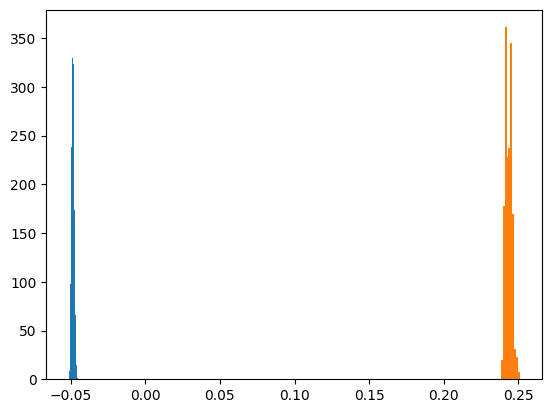

In [71]:
import matplotlib.pyplot as plt

plt.hist(out_graph.detach().squeeze())
plt.hist(out_ff.detach().squeeze())
plt.show()

In [74]:
torch.load('checkpoints/epoch=4-step=5.ckpt')

{'epoch': 4,
 'global_step': 5,
 'pytorch-lightning_version': '2.1.3',
 'state_dict': OrderedDict([('loss_fn.target_centers', tensor([-7.,  7.])),
              ('loss_fn.target_sigmas', tensor([0.2000, 0.2000])),
              ('nn.nn.0.weight',
               tensor([[ 0.1091, -0.1932, -0.1206, -0.0681,  0.1556,  0.1799,  0.1149, -0.2043,
                        -0.0908, -0.0390, -0.0684, -0.0457,  0.0788,  0.1463, -0.1411, -0.1737,
                         0.1678,  0.1805,  0.2164, -0.1644, -0.0258],
                       [ 0.1690,  0.1007, -0.0752,  0.1875,  0.1510,  0.0228,  0.1875,  0.2199,
                         0.0580,  0.1580,  0.1729,  0.1864, -0.0042,  0.1831,  0.1117,  0.0253,
                         0.0455,  0.2125, -0.1677,  0.0447, -0.1825],
                       [ 0.0161,  0.1482, -0.0858, -0.0592,  0.0975, -0.1783,  0.0376,  0.1408,
                         0.1791,  0.1822, -0.1982,  0.2098, -0.0159, -0.0619, -0.0960, -0.0942,
                        -0.1535,  0.0